# Projeto 2 - CDados

### Autores: Diego Guimarães Nuñez, Felipe Bakowski Nantes de Souza, Gustavo de Lima Mota

### Tema: Conseguimos prever o número de homicídios nos municípios do Estado de SP, que não são capital, em um ano no estado de São Paulo?

### Features: IDH por município, Proporção de crianças (6-14 anos) fora da escola, Proporção de vulnerabilidade socioeconêmica, Proporção de pessoas sem água e esgoto, e Índice de Gini por município.

### Fonte : basedosdados.org

In [90]:
import basedosdados as bd
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

### Baixando as bases de dados utilizadas no projeto:

In [91]:
homicidio = bd.read_table(dataset_id='br_sp_gov_ssp',
table_id='ocorrencias_registradas',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 153876/153876 [00:38<00:00, 4036.48rows/s]


In [92]:
ivs = bd.read_table(dataset_id='br_ipea_avs',
table_id='municipio',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 319681/319681 [07:28<00:00, 712.84rows/s] 


## Refletindo sobre os problemas sociais presentes em São Paulo, um dos mais notáveis é a abundante taxa de criminalidade, especificando ainda mais, a taxa de homicídio. Visado a target (problema o qual é pretendido visualizar), foi-se pensado em possíveis targets quais estão ligadas com o tema tido em vista, que são: Índice de Gini, Indice de desenvolvimento Humano, Proporcao de populacao sem esgoto, Proporcao de crianças que sairam da escola entre 6 a 14 anos e Proporcao de Vulnerabilidade Socioeconomica.
## Tendo em vista a target com suas respectivas features, é pretendido realizar a criação de um modelo com capacidade de previsão para a criminalidade, entendendo intrinsicamente as relações individuais de cada feature com a target. A partir da criação do modelo, é facilitada a visão das 'raízes' do problema, possibilitando possíveis tomadas de decisões pessoais e governamentais para tratar esse severo problema.

### Primeiramente, vamos tratar a base de dados de homicidios e deixá-la mais visualizável

### Além disso, estamos retirando a Capital SP da análise, pois, ela se comporta de maneira muito distinta em relação ao interior, resultando em dados muito aberrantes. Assim, consideramos que ela é um outlier e deve ser retirada para realizarmos uma melhor análise

In [93]:
homicidio['Homicidio_total'] = homicidio.loc[:, ['homicidio_doloso', 'homicidio_culposo_outros']].sum(axis=1) #homicidio total
homicidio_2010 = homicidio.loc[(homicidio['ano'] == 2010)]
homicidio_filtrado = homicidio_2010.loc[:,('ano','id_municipio', 'regiao_ssp', 'Homicidio_total')] #selecionando colunas
homicidio_ano = homicidio_filtrado.groupby(['ano', 'id_municipio', 'regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()

 ### Agora devemos tratar a base IVS, para que, consigamos utilizar as colunas:  Prop_crianca_fora_escola_6_14, IDHM (IDH por municipio), Proporção_vulnerabilidade_socioeconomica (proporção de pessoas com renda per capita inferior a meio salario mínimo e que gastam mais de uma hora até chegar no trabalho), proporção_sem_agua_esgoto, Índice de Gini

In [94]:
#filtrando ivs
ivs_filtrado = ivs.loc[:,('ano','id_municipio','sigla_uf','idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini')]
ivs_t = ivs_filtrado.loc[(ivs['sigla_uf'] == 'SP') & (ivs['ano'] == 2010)]
ivs_novo = ivs_t.dropna()
ivs_novo2 = ivs_novo.drop_duplicates(subset='id_municipio', keep = 'first')

#criando tabela 
tabela_final = pd.merge(ivs_novo2, homicidio_ano[['id_municipio', 'Homicidio_total']], on='id_municipio', how='left')
tabela_definitiva = tabela_final.dropna()
tabela_definitiva.loc[tabela_definitiva['Homicidio_total']==1260] # identificando São Paulo
tabela_sem_sp = tabela_definitiva.drop(tabela_definitiva.loc[tabela_definitiva['Homicidio_total']==1260].index) # tirando São Paulo
tabela_sem_sp.describe()

,ano,idhm,renda_per_capita,proporcao_analfabetismo_15_mais,proporcao_sem_renda_18_mais,indice_gini,Homicidio_total
count,639.0,639.000000,639.000000,639.000000,639.000000,639.000000,639.000000
mean,2010.0,0.763746,802.356620,6.071049,3.066182,0.456135,5.244131
std,0.0,0.034519,240.292539,2.441283,2.853549,0.059192,13.881830
min,2010.0,0.655000,348.790000,1.010000,0.000000,0.320000,0.000000
25%,2010.0,0.742000,649.415000,4.280000,1.290000,0.410000,0.000000
50%,2010.0,0.763000,761.590000,5.840000,2.080000,0.450000,1.000000
75%,2010.0,0.785000,904.240000,7.485000,3.835000,0.490000,4.000000
max,2010.0,0.891000,2729.860000,17.090000,24.480000,0.740000,168.000000


### Agora deve-se dividir o nosso dataframe em treino e teste

In [95]:
tabela_sem_sp = tabela_sem_sp.sample(frac=1) #mudando a ordem das linhas, a fim de, garantir que os df estejam equilibrados
df_treino = tabela_sem_sp[0:448]
df_teste = tabela_sem_sp[448:639]

### Entendendo como a target (homicídio) se comporta em relação aos municípios

### De início, tem-se um crosstab da porcentagem de homicícios, por município, em 2010.Além de, um gráfico de barras do homicídio, no Estado, dos municípios. Tal que, este será utilizado para a validação do modelo no futuro

In [96]:
homicidio_mun = homicidio.groupby(['ano','id_municipio','regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()
homicidio_mun = homicidio_mun.loc[(homicidio_mun['regiao_ssp']!='Capital')] #retirando a capital
homicidio_mun_2010 = homicidio_mun.loc[homicidio_mun.ano == 2010]

In [97]:
pd.crosstab(homicidio_mun_2010.Homicidio_total, homicidio_mun_2010.id_municipio, margins=True).round(4)

id_municipio,3500105,3500204,3500303,3500402,3500501,3500550,3500600,3500709,3500758,3500808,...,3556701,3556800,3556909,3556958,3557006,3557105,3557154,3557204,3557303,All
Homicidio_total,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,1,0,1,0,1,1,...,0,0,1,1,0,0,1,0,1,239
1.0,1,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,124
2.0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,58
3.0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,45
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24
6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,9
7.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


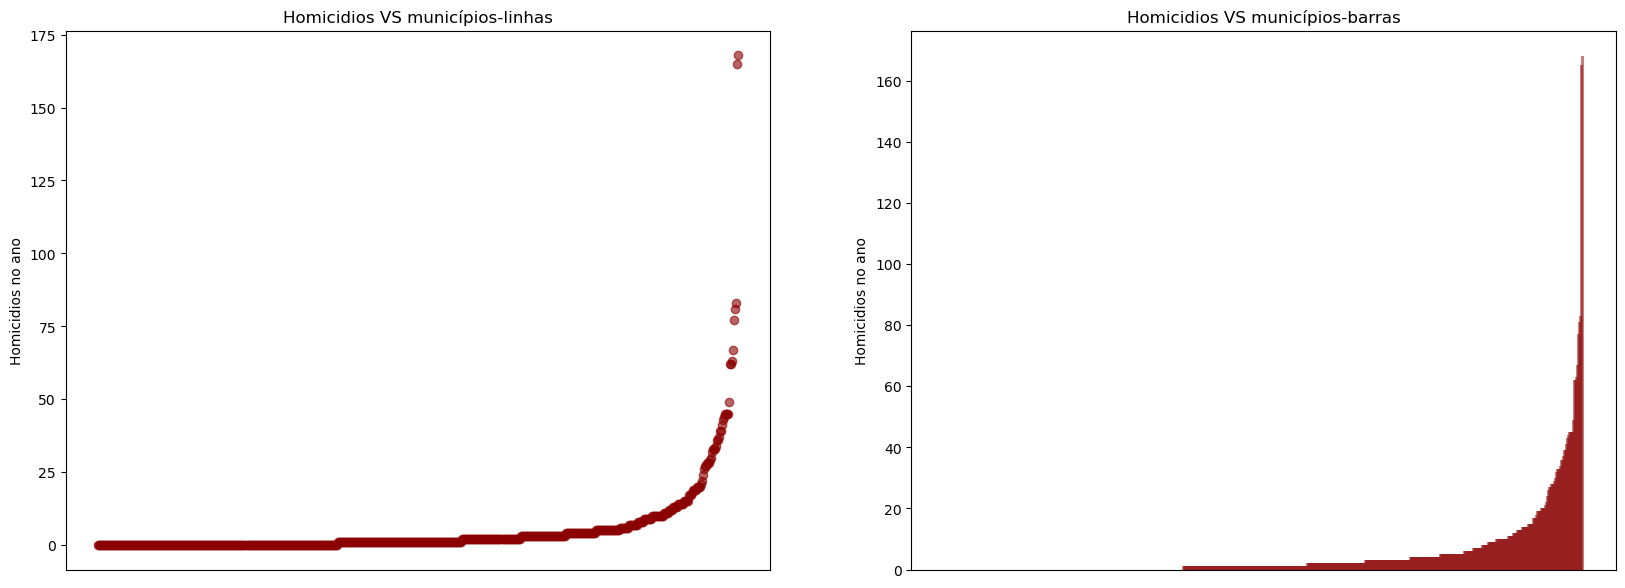

In [98]:
hom_ord = homicidio_mun_2010.sort_values('Homicidio_total')#ordenando os valores para ajudar na visibilidade

plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.scatter(hom_ord.id_municipio, hom_ord.Homicidio_total, color='darkred', alpha=0.6)
plt.xlabel('Municípios')
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Homicidios no ano')
plt.title('Homicidios VS municípios-linhas')

plt.subplot(1,2,2)
plt.bar(hom_ord.id_municipio, hom_ord.Homicidio_total, color='darkred', width=3, alpha=0.5)
plt.xlabel('Municípios')
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Homicidios no ano')
plt.title('Homicidios VS municípios-barras')


plt.show()

 ### Então, deve-se entender as correlações entre as features e variáveis, para que seja possível diagnosticar futuros erros

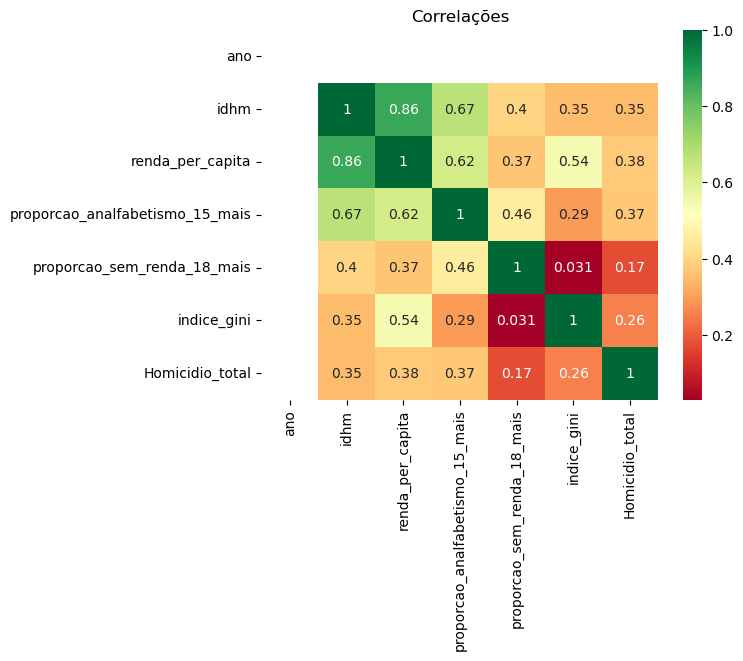

In [99]:
sns.heatmap(abs(tabela_sem_sp.corr()), annot = True, cmap= "RdYlGn") #nota : apenas para valores absolutos
plt.title('Correlações')
plt.show()

### Por fim, plota-se os gráficos de dispersão + .corr

### Nota: Esses gráficos de dispersão são referentes ao ano 2010

Correlação entre homicídios e idhm é moderada e possui valor de 0.3471078490441477
Correlação entre homicídios e renda per capita é moderada e possui valor de 0.3761556075810359
Correlação entre homicídios e prop. de analfabetismo é moderada e possui valor de -0.3716878242202825
Correlação entre homicídios e prop. pessoas sem renda é fraca e possui valor de -0.1733377810194884
Correlação entre homicídios e indice gini é fraca e possui valor de 0.2563769185726433


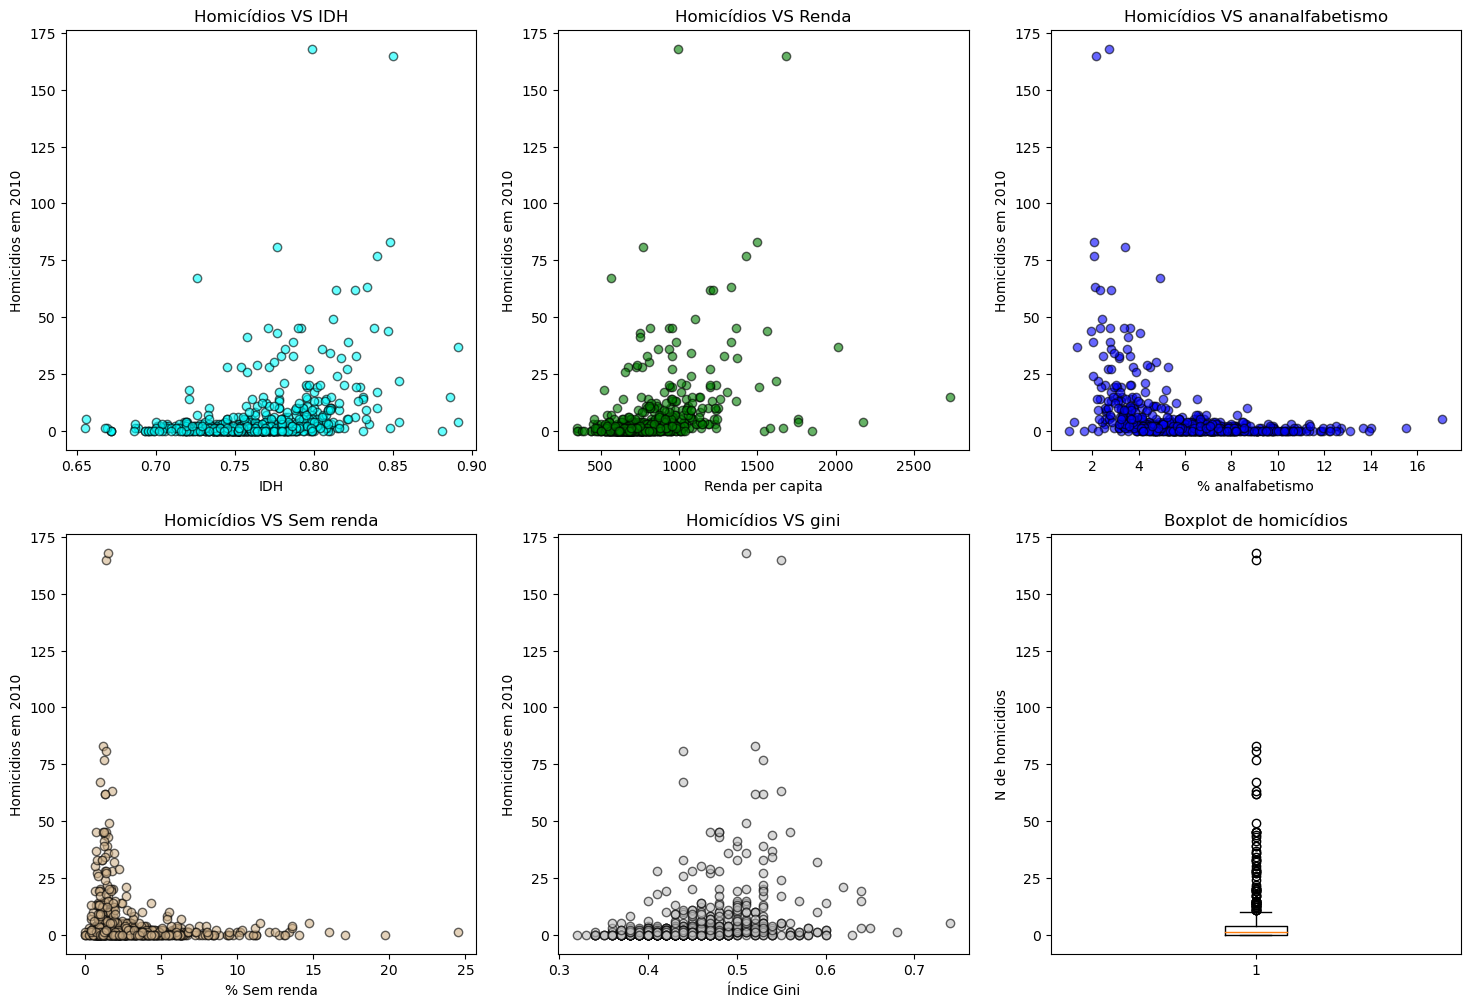

In [100]:
plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
plt.scatter(tabela_sem_sp['idhm'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='cyan', edgecolors="black")
plt.xlabel('IDH')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS IDH')
corr_idhm = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['idhm'])
if abs(corr_idhm) < 0.3:
    print(f'Correlação entre homicídios e idhm é fraca e possui valor de {corr_idhm}')
elif abs(corr_idhm) >0.3 and (corr_idhm) < 0.7:
    print(f'Correlação entre homicídios e idhm é moderada e possui valor de {corr_idhm}')
elif abs(corr_idhm) > 0.7:
    print(f'Correlação entre homicídios e idhm é forte e possui valor de {corr_idhm}')

plt.subplot(2,3,2)
plt.scatter(tabela_sem_sp['renda_per_capita'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='green', edgecolors="black")
plt.xlabel('Renda per capita')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS Renda')
corr_renda = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['renda_per_capita'])
if abs(corr_renda) < 0.3:
    print(f'Correlação entre homicídios e renda per capita é fraca e possui valor de {corr_renda}')
elif abs(corr_renda) >0.3 and (corr_renda) < 0.7:
    print(f'Correlação entre homicídios e renda per capita é moderada e possui valor de {corr_renda}')
elif abs(corr_renda) > 0.7:
    print(f'Correlação entre homicídios e renda per capita é forte e possui valor de {corr_renda}')

plt.subplot(2,3,3)
plt.scatter(tabela_sem_sp['proporcao_analfabetismo_15_mais'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='blue', edgecolors="black")
plt.xlabel('% analfabetismo')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS ananalfabetismo')
corr_analfab = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['proporcao_analfabetismo_15_mais'])
if abs(corr_analfab) < 0.3:
    print(f'Correlação entre homicídios e prop. de analfabetismo é fraca e possui valor de {corr_analfab}')
elif abs(corr_analfab) >0.3 and (corr_analfab) < 0.7:
    print(f'Correlação entre homicídios e prop. de analfabetismo é moderada e possui valor de {corr_analfab}')
elif abs(corr_analfab) > 0.7:
    print(f'Correlação entre homicídios e prop. de analfabetismo é forte e possui valor de {corr_analfab}')

plt.subplot(2,3,4)
plt.scatter(tabela_sem_sp['proporcao_sem_renda_18_mais'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='tan', edgecolors="black")
plt.xlabel('% Sem renda')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS Sem renda')
corr_sem_renda = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['proporcao_sem_renda_18_mais'])
if abs(corr_sem_renda) < 0.3:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é fraca e possui valor de {corr_sem_renda}')
elif abs(corr_sem_renda) >0.3 and (corr_sem_renda) < 0.7:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é moderada e possui valor de {corr_sem_renda}')
elif abs(corr_sem_renda) > 0.7:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é forte e possui valor de {corr_sem_renda}')

plt.subplot(2,3,5)
plt.scatter(tabela_sem_sp['indice_gini'], tabela_sem_sp['Homicidio_total'], alpha=0.6, color='silver', edgecolors="black")
plt.xlabel('Índice Gini')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS gini')
corr_gini = tabela_sem_sp['Homicidio_total'].corr(tabela_sem_sp['indice_gini'])
if abs(corr_gini) < 0.3:
    print(f'Correlação entre homicídios e indice gini é fraca e possui valor de {corr_gini}')
elif abs(corr_gini) >0.3 and (corr_gini) < 0.7:
    print(f'Correlação entre homicídios e indice gini é moderada e possui valor de {corr_gini}')
elif abs(corr_gini) > 0.7:
    print(f'Correlação entre homicídios e indice gini é forte e possui valor de {corr_gini}')

plt.subplot(2,3,6)
plt.boxplot(tabela_sem_sp['Homicidio_total'])
plt.title('Boxplot de homicídios')
plt.ylabel('N de homicidios')

plt.show()

### Possíveis fontes de erro:

### Ao analisarmos a função .agg observamos que ela fazia com que existisse alguns pontos aberrantes, por exemplo, em sp tinhamos 1260 homicídios. Logo, tiramos esse ponto aberrante e trabalharemos com essa possibilidade de erro para as próximas análises

### Agora iremos criar um modelo de regressão linear com múltiplas variáveis, utilizando o df treino

In [101]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [102]:
X = df_treino[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini']]

Y = df_treino['Homicidio_total']

In [103]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     17.06
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           1.95e-15
Time:                        12:07:51   Log-Likelihood:                -1805.8
No. Observations:                 448   AIC:                             3624.
Df Residuals:                     442   BIC:                             3648.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               4.0229     30.961      0.130      0.897     -56.825      64.871
idhm                              -13.0535     41.853     -0.312      0.755     -95.309      69.202
renda_per_capita                    0.0138      0.007      2.067      0.039       0.001       0.027
proporcao_analfabetismo_15_mais    -1.3611      0.387     -3.513      0.000      -2.122      -0.600
proporcao_sem_renda_18_mais        -0.0113      0.256     -0.044      0.965      -0.514       0.491
indice_gini                        18.3385     14.164      1.295      0.196      -9.498      46.175
==============================================================================
Omnibus:                      602.151   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80945.115
Skew:                           6.711   Prob(JB):                         0.00
Kurtosis:                      67.469   Cond. No.                     6.72e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Então, precisamos analisar quais variáveis serão desejáveis para a análise. Para isso iremos utilizar um processo iterativo de rodar o modelo e avaliar se o valor P está acima de 10% (índice de significância), caso esteja, ele deverá ser retirado e rodaremos o modelo denovo até que achemos todas as variáveis relevantes.

In [151]:
X = df_treino[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais','indice_gini']] #retirando prop_rem_renda+18

Y = df_treino['Homicidio_total']

In [152]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     21.37
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           3.92e-16
Time:                        12:41:48   Log-Likelihood:                -1805.8
No. Observations:                 448   AIC:                             3622.
Df Residuals:                     443   BIC:                             3642.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               4.0776     30.901      0.132      0.895     -56.653      64.808
idhm                              -13.1009     41.792     -0.313      0.754     -95.236      69.034
renda_per_capita                    0.0138      0.007      2.098      0.037       0.001       0.027
proporcao_analfabetismo_15_mais    -1.3659      0.371     -3.682      0.000      -2.095      -0.637
indice_gini                        18.2125     13.858      1.314      0.189      -9.022      45.447
==============================================================================
Omnibus:                      602.090   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80908.756
Skew:                           6.709   Prob(JB):                         0.00
Kurtosis:                      67.454   Cond. No.                     6.71e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [153]:
X = df_treino[['renda_per_capita','proporcao_analfabetismo_15_mais','indice_gini']] #retirando idhm
Y = df_treino['Homicidio_total']

In [154]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     28.52
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           7.02e-17
Time:                        12:42:25   Log-Likelihood:                -1805.8
No. Observations:                 448   AIC:                             3620.
Df Residuals:                     444   BIC:                             3636.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -5.4030      6.335     -0.853      0.394     -17.854       7.048
renda_per_capita                    0.0122      0.004      2.995      0.003       0.004       0.020
proporcao_analfabetismo_15_mais    -1.3347      0.357     -3.738      0.000      -2.036      -0.633
indice_gini                        19.4961     13.225      1.474      0.141      -6.496      45.488
==============================================================================
Omnibus:                      602.611   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            81149.400
Skew:                           6.720   Prob(JB):                         0.00
Kurtosis:                      67.550   Cond. No.                     1.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
X = df_treino[['renda_per_capita','proporcao_analfabetismo_15_mais']] #retirando indice_gini
Y = df_treino['Homicidio_total']

In [159]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     41.58
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           2.78e-17
Time:                        12:43:06   Log-Likelihood:                -1806.9
No. Observations:                 448   AIC:                             3620.
Df Residuals:                     445   BIC:                             3632.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.9955      4.621      0.215      0.830      -8.086      10.077
renda_per_capita                    0.0150      0.004      4.163      0.000       0.008       0.022
proporcao_analfabetismo_15_mais    -1.2941      0.356     -3.630      0.000      -1.995      -0.594
==============================================================================
Omnibus:                      601.402   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80262.062
Skew:                           6.698   Prob(JB):                         0.00
Kurtosis:                      67.189   Cond. No.                     5.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Agora que apenas as features relevantes sobraram, devemos análisar a correlação entre os erros do modelo. Para isso, utilizaremos o valor de Durbin-Watson.

### No caso, esse valor é de 2,060

In [162]:
resultado = 2*(1-2.060)

In [163]:
resultado

-2.12

### Como esse resultado está muito próximo de 2, pode-se afirmar que a correlação entre os erros é bem baixa !

### Agora, nós podemos fazer uma análise da nossa regressão linear composta e avaliar se ela responde a nossa pergunta inicial. Para isso, iremos calcular a diferença entre os valores reais e os criados pelo modelo, a fim de, realizar uma análise exploratória neles e compreender seu funcionamento

In [188]:
y = modelo_regress.predict()
df_modelo1 = df_treino.loc[:, ('id_municipio', 'Homicidio_total', 'proporcao_analfabetismo_15_mais','renda_per_capita')]
df_modelo1['y'] = y
df_modelo1['diferença'] = df_modelo1.Homicidio_total-df_modelo1.y
df_modelo1 = df_modelo1.sort_values('diferença')

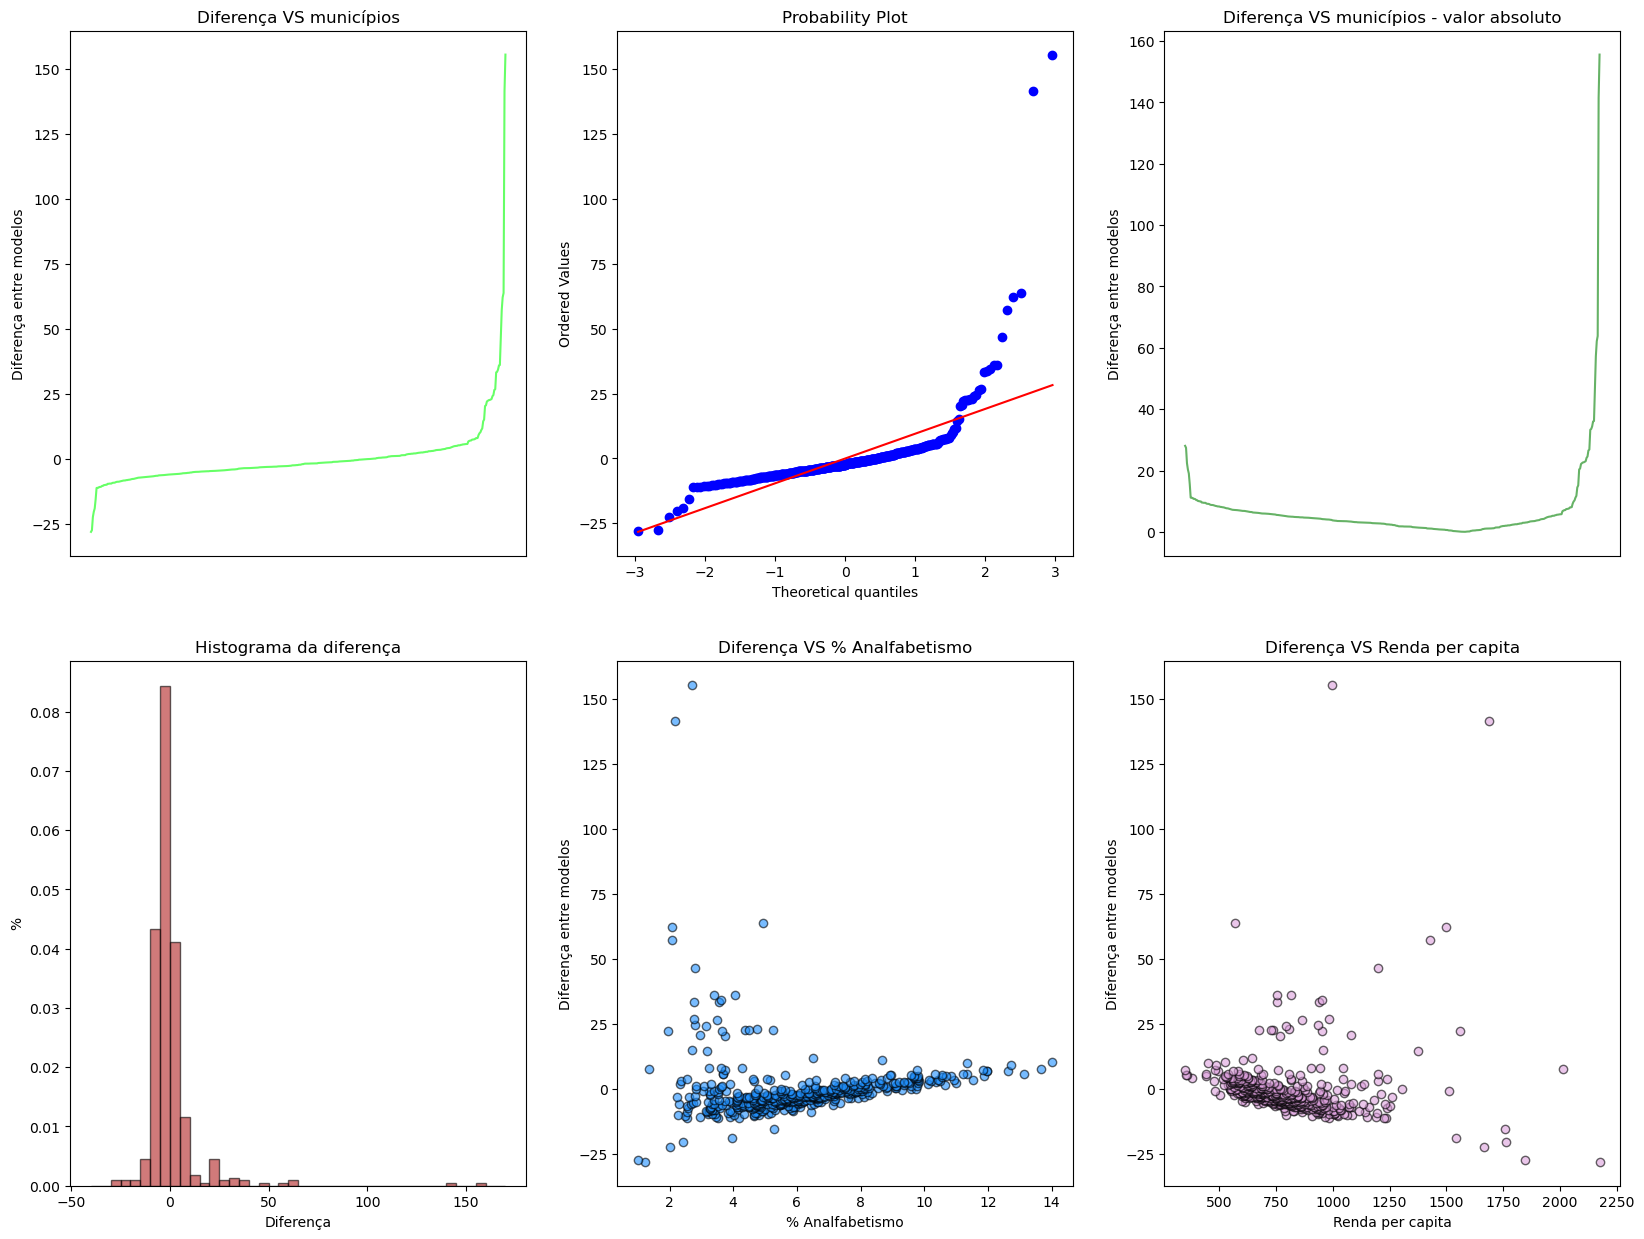

In [199]:
%matplotlib inline
plt.figure(figsize=(20,15))

#diferença entre os dois modelos
plt.subplot(2,3,1)
plt.plot(df_modelo1.id_municipio, df_modelo1.diferença, color='lime', alpha=0.6)
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Diferença entre modelos')
plt.title('Diferença VS municípios')

#probplot dos resíduis
plt.subplot(2,3,2)
stats.probplot(df_modelo1.diferença, dist='norm', plot=plt)

#diferença vc municípios em absoluto
plt.subplot(2,3,3)
plt.plot(df_modelo1.id_municipio, abs(df_modelo1.diferença), color='g', alpha=0.6)
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Diferença entre modelos')
plt.title('Diferença VS municípios - valor absoluto')

#Histograma da diferença
plt.subplot(2,3,4)
bins = np.arange(-40, 175, 5)
plt.hist(df_modelo1.diferença, bins=bins, density=True, color='firebrick', edgecolor='black', alpha=0.6)
plt.ylabel('%')
plt.xlabel('Diferença')
plt.title('Histograma da diferença')

#Diferença vs analfabetismo
plt.subplot(2,3,5)
plt.scatter(df_modelo1.proporcao_analfabetismo_15_mais, df_modelo1.diferença, color='dodgerblue', alpha=0.6, edgecolors='black')
plt.ylabel('Diferença entre modelos')
plt.xlabel('% Analfabetismo')
plt.title('Diferença VS % Analfabetismo')

#Diferença vs renda per capita
plt.subplot(2,3,6)
plt.scatter(df_modelo1.renda_per_capita, df_modelo1.diferença, color='plum', alpha=0.6, edgecolors='black')
plt.ylabel('Diferença entre modelos')
plt.xlabel('Renda per capita')
plt.title('Diferença VS Renda per capita')

plt.show()

 ### Fazendo um mapa de calor para melhor visualizar as correlações

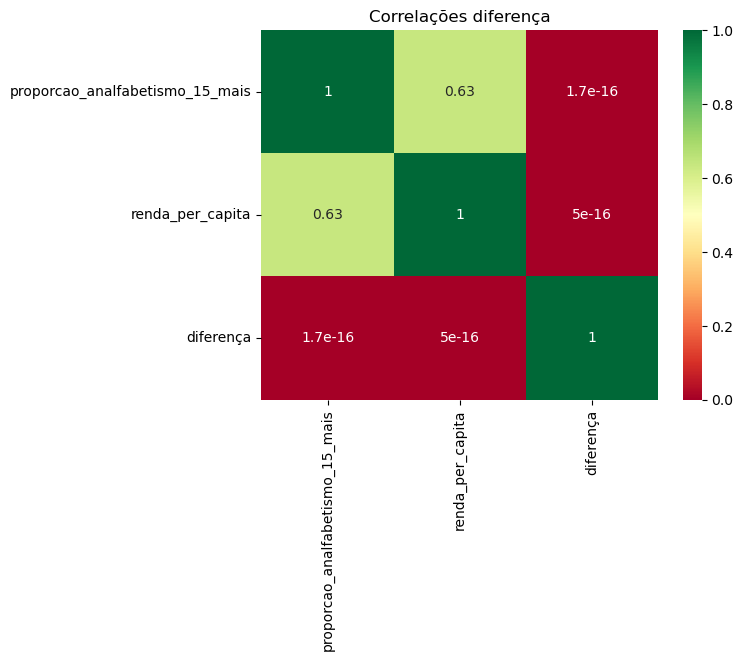

In [193]:
heatmap = df_modelo1.loc[:, ('proporcao_analfabetismo_15_mais', 'renda_per_capita', 'diferença')]
sns.heatmap(abs(heatmap.corr()), annot = True, cmap= "RdYlGn") #nota : apenas para valores absolutos
plt.title('Correlações diferença')
plt.show()

 ### Agora, iremos plotar um gráfico 3D da diferença entre modelos por suas targets. Entretanto, para visualizá-lo deve-se abrir o arquivo no jupyter

In [196]:
beta0_hat = modelo_regress.params[0]  
beta1_hat = modelo_regress.params[1]  
beta2_hat = modelo_regress.params[2]  

def f(feature1, feature2):
    return beta0_hat + beta1_hat*feature1 + beta2_hat*feature2

In [197]:
%matplotlib notebook

npoints = 100
feature1 = df_treino['renda_per_capita']
feature2 = df_treino['proporcao_analfabetismo_15_mais']
x_vc = np.linspace(feature1.min(), feature1.max(), npoints)
y_vc = np.linspace(feature2.min(), feature2.max(), npoints)

eixo_x, eixo_y = np.meshgrid(x_vc, y_vc)

fit_z = f(eixo_x, eixo_y)

plt3d = plt.subplot(projection='3d')
plt3d.plot_surface(eixo_x, eixo_y, fit_z)
plt3d.scatter(feature1, feature2, Y, color="r")
plt3d.set_xlabel("Renda per capita")
plt3d.set_ylabel("Proporção Analfabetismo")
plt3d.set_zlabel("Previsão")
plt.show()

<IPython.core.display.Javascript object>

 ### Validando a regressão linear

In [119]:
cross = pd.DataFrame()
cross[['Treino','Teste','Fold1','Fold2','Fold3','Fold4','Fold5','Fold6','Fold7','Fold8','Fold9','Fold10']] = ''
cross.loc['N de linhas'] = ''
cross.loc['R2'] = ''
cross.loc['MSE'] = ''
cross.loc['RMSE'] = ''
cross.loc['MAE'] = ''
cross.loc['RMSLE'] = ''
cross.loc['Desvio residual'] = ''
cross.loc['Med desvio residual'] = ''
cross.loc['Desvio nulo'] = ''
cross.loc['Graus de liberade nulos'] = ''
cross.loc['Residuos graus de liberdade'] = ''


In [120]:
cross

,Treino,Teste,Fold1,Fold2,Fold3,Fold4,Fold5,Fold6,Fold7,Fold8,Fold9,Fold10
N de linhas,,,,,,,,,,,,
R2,,,,,,,,,,,,
MSE,,,,,,,,,,,,
RMSE,,,,,,,,,,,,
MAE,,,,,,,,,,,,
RMSLE,,,,,,,,,,,,
Desvio residual,,,,,,,,,,,,
Med desvio residual,,,,,,,,,,,,
Desvio nulo,,,,,,,,,,,,
Graus de liberade nulos,,,,,,,,,,,,


In [134]:
cross.loc['N de linhas','Treino'] = r2_score(df_modelo1.Homicidio_total,y)


In [135]:
cross

,Treino,Teste,Fold1,Fold2,Fold3,Fold4,Fold5,Fold6,Fold7,Fold8,Fold9,Fold10
N de linhas,-0.23546,,,,,,,,,,,
R2,,,,,,,,,,,,
MSE,,,,,,,,,,,,
RMSE,,,,,,,,,,,,
MAE,,,,,,,,,,,,
RMSLE,,,,,,,,,,,,
Desvio residual,,,,,,,,,,,,
Med desvio residual,,,,,,,,,,,,
Desvio nulo,,,,,,,,,,,,
Graus de liberade nulos,,,,,,,,,,,,


## Com a nossa regressão linear completa, agora devemos utilizar uma segunda técnica de predição para criar um outro modelo. Esta será feito através de uma arvore de decisões

In [129]:
arvore_regressao = DecisionTreeRegressor()

Xa = df_treino[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini']]
Ya = df_treino['Homicidio_total']

arvore_regressao.fit(Xa, Ya) #criando árvore de regressão

DecisionTreeRegressor()

 ### Validando

In [130]:
Xteste = df_teste[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini']]
Yteste = df_teste['Homicidio_total']

prev_y = arvore_regressao.predict(Xteste)

mae = mean_absolute_error(Yteste, prev_y)
mse = mean_squared_error(Yteste, prev_y)
r2 = r2_score(Yteste, prev_y)

print(mae)
print(mse)
print(r2)

6.664921465968586
271.3350785340314
-1.1814224040091066
